In [1]:
import os
import time
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import scipy.signal as sig
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [4]:
atlas_file = 'D:\\aal_from_france\\aal\\ext-d000035_AAL1Atlas_pub-Release2018_SPM12\\aal_for_SPM12\\atlas\\AAL.nii'
atlas = nib.load(atlas_file)
print( atlas )


<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 9170.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL3.3\x00m single_subj_T1_111'
aux_file        : b''
qform_co

In [5]:
atlas_flat = torch.from_numpy( atlas.get_fdata() ).to(device=device).flatten(start_dim=0, end_dim=2)
print( atlas_flat.size() )

torch.Size([902629])


In [6]:
roi_list = torch.unique(atlas_flat)
print( roi_list.size() )

torch.Size([117])


In [7]:
voxel_to_roi_mat = ( roi_list.unsqueeze(dim=1) == atlas_flat.unsqueeze(dim=0) ).double()
voxel_to_roi_mat /= voxel_to_roi_mat.sum(dim=-1, keepdim=True)
print( voxel_to_roi_mat.size() )

torch.Size([117, 902629])


In [8]:
data_file = 'D:\\hcp_from_s3_second_try\\100206'
data_file_better = 'D:\\hcp_from_s3_second_try\\100206.nii.gz'
os.rename(data_file, data_file_better)
data = nib.load(data_file_better)
print(data)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'D:\\hcp_from_s3_second_try\\100206' -> 'D:\\hcp_from_s3_second_try\\100206.nii.gz'

In [8]:
# data_file = 'D:\\hcp_from_s3_second_try\\100206'
data_file_better = 'D:\\hcp_from_s3_second_try\\100206.nii.gz'
# os.rename(data_file, data_file_better)
data = nib.load(data_file_better)
print(data)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 1200)
affine:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   4   91  109   91 1200    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    2.    0.72  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qfo

In [9]:
data_flat = torch.from_numpy( data.get_fdata() ).flatten(start_dim=0, end_dim=2).to(device=device)
print( data_flat.size() )

torch.Size([902629, 1200])


In [10]:
data_by_roi = torch.matmul(voxel_to_roi_mat, data_flat)
print( data_by_roi.size() )

torch.Size([117, 1200])


In [ ]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.plot( depytorch(data_by_roi[0,:]) )

In [1]:
b, a = sig.cheby2(N=5, rs=40, Wn=[0.01, 0.1], btype='bandpass', analog=False, output='ba', fs=1/0.72)
data_by_roi_bp = sig.filtfilt( b=b, a=a, x=depytorch(data_by_roi), axis=-1 )
print( data_by_roi_bp.shape )

NameError: name 'sig' is not defined

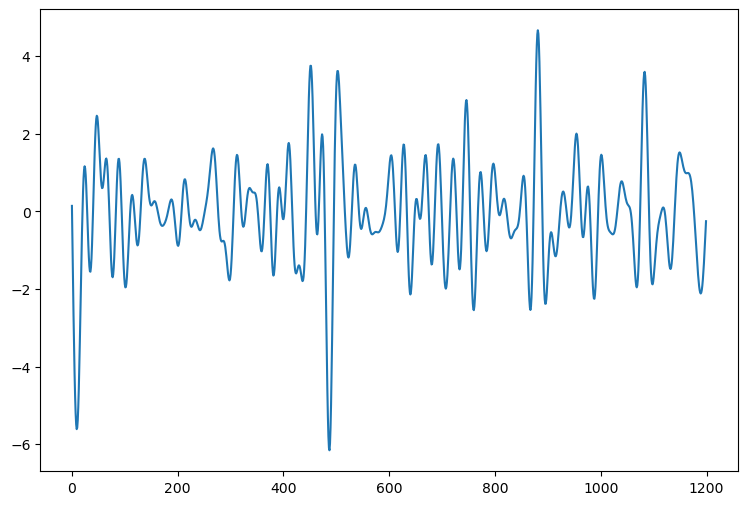

In [21]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.plot(data_by_roi_bp[0,:])

In [26]:
data_mean = np.mean(data_by_roi_bp, axis=-1, keepdims=True)
data_std = np.std(data_by_roi_bp, axis=-1, keepdims=True)
data_by_roi_bp_z = (data_by_roi_bp - data_mean)/data_std
print( data_by_roi_bp_z.shape )

(117, 1200)


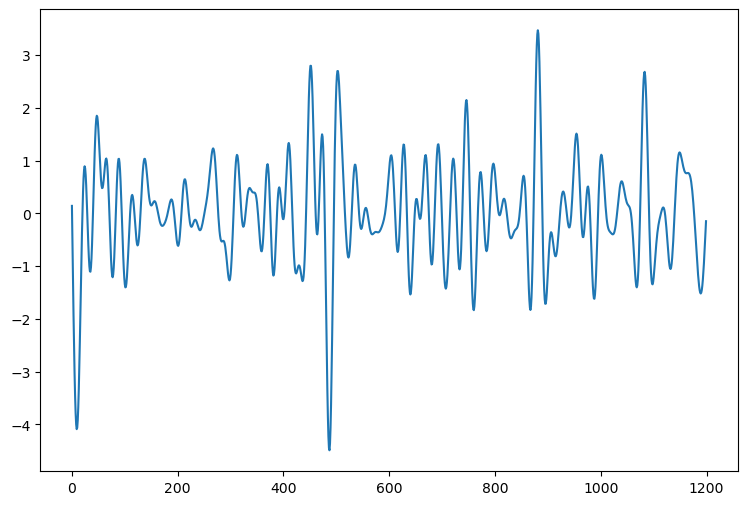

In [27]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.plot(data_by_roi_bp_z[0,:])

In [9]:
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'berlin',
 'managua',
 'vanimo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',

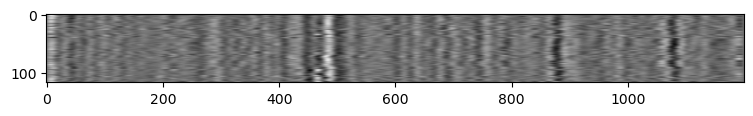

In [39]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow(data_by_roi_bp_z, cmap='binary')

In [ ]:
data_by_roi_bp_tensor = torch.from_numpy(data_by_roi_bp).to(device=device)
data_std, data_mean = torch.std_mean(data_by_roi_bp_tensor, dim=-1, keepdin=True)
data_z = (data_by_roi_bp_tensor - data_mean)/data_std

In [4]:
# made and saved this one separately in parcellate_and_bandpass_fmri_data.py
data_z = torch.load('D:\\fmri_aal\\100206_rest_1_lr.pt', weights_only=True)
print( data_z.size() )

torch.Size([117, 1200])


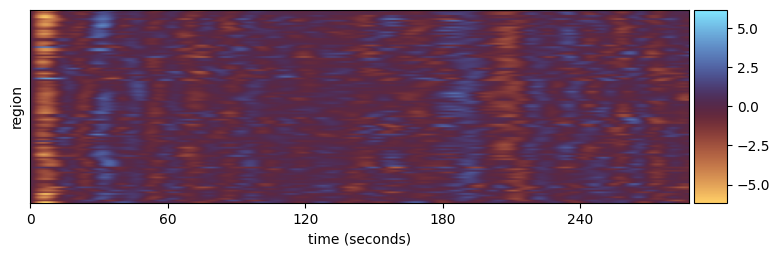

In [43]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
max_time_index = 400
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )
# cmap = 'berlin_r'
# cmap = 'bwr_r'
cmap = 'managua'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'
shown_image = axs.imshow( depytorch(data_z_to_plot), cmap=cmap, vmin=-max_abs, vmax=max_abs )
seconds_per_index = 0.72
seconds_per_tick = 60
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs.set_yticks([])
axs.set_ylabel('region')
axs.set_xticks( depytorch(tick_time_indices) )
axs.set_xticklabels([ f'{t:.3g}' for t in tick_times ])
axs.set_xlabel('time (seconds)')
fig.colorbar(shown_image, cax=cax, orientation='vertical')

Text(0, 0.5, 'BOLD signal (z-score)')

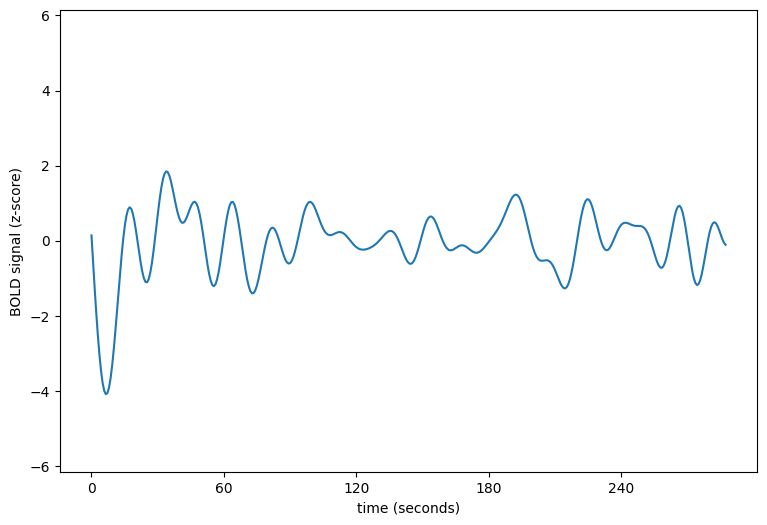

In [47]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.plot( depytorch(data_z[0,:max_time_index]) )
axs.set_xticks( depytorch(tick_time_indices) )
axs.set_xticklabels([ f'{t:.3g}' for t in tick_times ])
axs.set_xlabel('time (seconds)')
axs.set_ylim([depytorch(-max_abs), depytorch(max_abs)])
axs.set_ylabel('BOLD signal (z-score)')

In [48]:
fc_original = torch.matmul( data_z, data_z.transpose(dim0=0, dim1=1) )/data_z.size(dim=-1)
print( fc_original.size() )

torch.Size([117, 117])


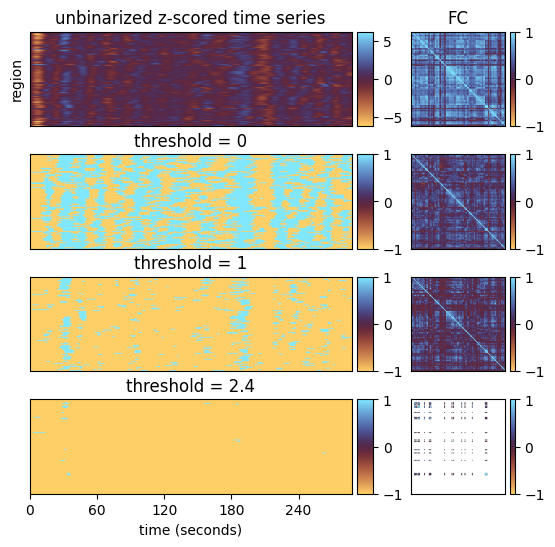

In [99]:
def get_fc(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )/( ts_std.unsqueeze(dim=1) * ts_std.unsqueeze(dim=0) )

fig, axs = plt.subplots( nrows=4, ncols=2, figsize=(9, 6) )

max_time_index = 400

# Plot the unbinarized time series.
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )
# cmap = 'berlin_r'
# cmap = 'bwr_r'
cmap = 'managua'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'

shown_image = axs[0,0].imshow( depytorch(data_z_to_plot), cmap=cmap, vmin=-max_abs, vmax=max_abs )
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('region')
axs[0,0].set_title('unbinarized z-scored time series')

# Plot the FC of the unbinarized data.
fc_original = get_fc(data_z)
shown_image = axs[0,1].imshow( depytorch(fc_original), cmap=cmap, vmin=-1, vmax=1 )
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('FC')

for threshold, row_index in zip([0.0, 1.0, 2.4],[1, 2, 3]):
    # Plot the binarized time series.
    binarized_ts = 2.0*(data_z_to_plot >= threshold).float() - 1.0
    axs[row_index,0].imshow( depytorch(binarized_ts), cmap=cmap, vmin=-1.0, vmax=1.0 )
    divider = make_axes_locatable(axs[row_index,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,0].set_xticks([])
    axs[row_index,0].set_yticks([])
    axs[row_index,0].set_title(f'threshold = {threshold:.3g}')
    # Plot the FC of the binarized time series.
    binarized_fc = get_fc(binarized_ts)
    shown_image = axs[row_index,1].imshow( depytorch(binarized_fc), cmap=cmap, vmin=-1, vmax=1 )
    divider = make_axes_locatable(axs[row_index,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,1].set_xticks([])
    axs[row_index,1].set_yticks([])
    axs[row_index,1].set_anchor('W')

seconds_per_index = 0.72
seconds_per_tick = 60
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs[3,0].set_xticks( depytorch(tick_time_indices) )
axs[3,0].set_xticklabels([ f'{t:.3g}' for t in tick_times ]) 
axs[3,0].set_xlabel('time (seconds)')

# fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=-0.4)
plt.show()

In [ ]:
def get_cov(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )

fig, axs = plt.subplots( nrows=4, ncols=2, figsize=(9, 6) )

max_time_index = 400

# Plot the unbinarized time series.
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )
# cmap = 'berlin_r'
# cmap = 'bwr_r'
cmap = 'managua'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'

shown_image = axs[0,0].imshow( depytorch(data_z_to_plot), cmap=cmap, vmin=-max_abs, vmax=max_abs )
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('region')
axs[0,0].set_title('unbinarized z-scored time series')

# Plot the FC of the unbinarized data.
cov_original = get_cov(data_z)
shown_image = axs[0,1].imshow( depytorch(cov_original), cmap=cmap, vmin=-1, vmax=1 )
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('covariance')

for threshold, row_index in zip([0.0, 1.0, 2.4],[1, 2, 3]):
    # Plot the binarized time series.
    binarized_ts = 2.0*(data_z_to_plot >= threshold).float() - 1.0
    axs[row_index,0].imshow( depytorch(binarized_ts), cmap=cmap, vmin=-1.0, vmax=1.0 )
    divider = make_axes_locatable(axs[row_index,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,0].set_xticks([])
    axs[row_index,0].set_yticks([])
    axs[row_index,0].set_title(f'threshold = {threshold:.3g}')
    # Plot the FC of the binarized time series.
    binarized_cov = get_cov(binarized_ts)
    shown_image = axs[row_index,1].imshow( depytorch(binarized_cov), cmap=cmap, vmin=-1, vmax=1 )
    divider = make_axes_locatable(axs[row_index,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,1].set_xticks([])
    axs[row_index,1].set_yticks([])
    axs[row_index,1].set_anchor('W')

seconds_per_index = 0.72
seconds_per_tick = 60
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs[3,0].set_xticks( depytorch(tick_time_indices) )
axs[3,0].set_xticklabels([ f'{t:.3g}' for t in tick_times ]) 
axs[3,0].set_xlabel('time (seconds)')

# fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=-0.4)
plt.show()

In [ ]:
subject_id = '100206'
data_file = os.path.join('D:\\hcp_from_s3_second_try', subject_id)
print(data_file)
print( os.path.isfile(data_file) )

In [20]:
code_start_time = time.time()
with open(file='D:\\HCP_data\\Subj_list.txt', mode='r') as subject_list_file:
    for subject_id in subject_list_file.readlines():
        subject_id = subject_id.rstrip()
        data_file = os.path.join('D:\\hcp_from_s3_second_try', subject_id)
        print( f'{time.time() - code_start_time:.3f}, checking for file {data_file}...', os.path.isfile(path=data_file) )

0.001, checking for file D:\hcp_from_s3_second_try\100206... True
0.001, checking for file D:\hcp_from_s3_second_try\100307... True
0.001, checking for file D:\hcp_from_s3_second_try\100408... True
0.001, checking for file D:\hcp_from_s3_second_try\100610... True
0.002, checking for file D:\hcp_from_s3_second_try\101006... True
0.002, checking for file D:\hcp_from_s3_second_try\101107... True
0.002, checking for file D:\hcp_from_s3_second_try\101309... True
0.002, checking for file D:\hcp_from_s3_second_try\101915... True
0.002, checking for file D:\hcp_from_s3_second_try\102008... True
0.002, checking for file D:\hcp_from_s3_second_try\102109... True
0.002, checking for file D:\hcp_from_s3_second_try\102311... True
0.002, checking for file D:\hcp_from_s3_second_try\102513... True
0.002, checking for file D:\hcp_from_s3_second_try\102614... True
0.002, checking for file D:\hcp_from_s3_second_try\102715... True
0.002, checking for file D:\hcp_from_s3_second_try\102816... True
0.002, che